In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib
import math


In [186]:
# CSVファイルを読み込む
file_path = "./logs/terminal_coordinate/"

df_gyro = pd.read_csv(
    f"{file_path}Gyroscope.csv",
    header=0,
    names=("time", "x", "y", "z")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)


In [187]:
# 角速度から角度を計算する
t = df_gyro['time'].max() - df_gyro['time'].min()
n = len(df_gyro)
a = np.degrees(t/n)

df_gyro['i_x'] = np.cumsum(df_gyro['x']) * a
df_gyro['i_y'] = np.cumsum(df_gyro['y']) * a
df_gyro['i_z'] = np.cumsum(df_gyro['z']) * a


In [188]:
# グラフを描画する
def plot(
    df,
    heads=[],
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    grid=True,
):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if grid:
        plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    for head in heads:
        plt.plot(df[head[0]], df[head[1]], label=head[1])

    plt.legend()

    plt.show()


In [189]:
def rotate(vec, pitch, roll, yaw):
    r_x = np.array([
        [1, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch)],
        [0, np.sin(pitch), np.cos(pitch)]
    ])
    r_y = np.array([
        [np.cos(roll), 0, np.sin(roll)],
        [0, 1, 0],
        [-np.sin(roll), 0, np.cos(roll)]
    ])
    r_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    vec = np.dot(r_x, vec)
    vec = np.dot(r_y, vec)
    vec = np.dot(r_z, vec)

    return vec


In [190]:
def calculate_tilt(df):
    tilt_angles = []  # 傾きを格納するリスト

    # df を for で回す
    for d in df.itertuples(index=False):
        time = d.time
        x = d.x
        y = d.y
        z = d.z
        
        gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

        # 重力方向となす角度を計算
        tilt_angle_x = math.acos(x / gravity)
        tilt_angle_y = math.acos(y / gravity)
        tilt_angle_z = math.acos(z / gravity)

        tilt_angles.append((time, tilt_angle_x, tilt_angle_y, tilt_angle_z))

    df_tilt = pd.DataFrame(tilt_angles, columns=["time", "roll", "pitch", "yaw"])
    return df_tilt


In [191]:
def get_nearest_time(df, target_time):
    # "time"列と目標時間との差分を計算
    df['time_diff'] = (df['time'] - target_time).abs()

    # 差分の絶対値が最小となる行を取得
    nearest_row = df.loc[df['time_diff'].idxmin()]

    # 最も近い時間の値を取得
    nearest_time = nearest_row['time']

    # "time_diff"列を削除
    df = df.drop(columns=['time_diff'])

    return nearest_time


In [192]:
# 端末座標系を端末の向きに合わせて回転させる
def rotate_device_coordinate_system(df):
    new_df = []
    for data in df.iterrows():
        # 元のベクトル
        x = data[1]['x']
        y = data[1]['y']
        z = data[1]['z']

        vec = np.array([x, y, z])

        # 回転後のベクトル
        vec_dash = rotate(
            vec,
            data[1]['yaw'],
            data[1]['roll'],
            data[1]['pitch']
        )

        # 回転後の値を格納
        new_df.append([
            data[1]['time'],
            vec_dash[0],
            vec_dash[1],
            vec_dash[2],
        ])

    new_df = pd.DataFrame(new_df, columns=['time', 'x', 'y', 'z'])
    return new_df


In [193]:
df_tilt = calculate_tilt(df_acc)
df_tilt['roll'] = df_tilt['roll'] - np.radians(90)
df_tilt['pitch'] = df_tilt['pitch'] - np.radians(90)

tilts = []
for data in df_acc.iterrows():
    time = data[1]['time']
    nearest_time = get_nearest_time(df_tilt, time)

    # 傾きを取得
    tilt = df_tilt[df_tilt['time'] == nearest_time]
    tilts.append((
        tilt['pitch'].values[0],
        tilt['roll'].values[0],
        tilt['yaw'].values[0]
    ))

tilts = np.array(tilts)

# df_acc に "roll", "pitch", "yaw" 列を追加
df_acc['pitch'] = tilts[:, 0]
df_acc['roll'] = tilts[:, 1]
df_acc['yaw'] = tilts[:, 2]


       time         x         y         z
0  0.018635  0.001888 -0.198206  9.725982
1  0.021016  0.001664 -0.184702  9.735729
2  0.023398  0.001381 -0.171662  9.721574
3  0.025780  0.001667 -0.184702  9.721369
4  0.028161  0.002035 -0.203181  9.721094


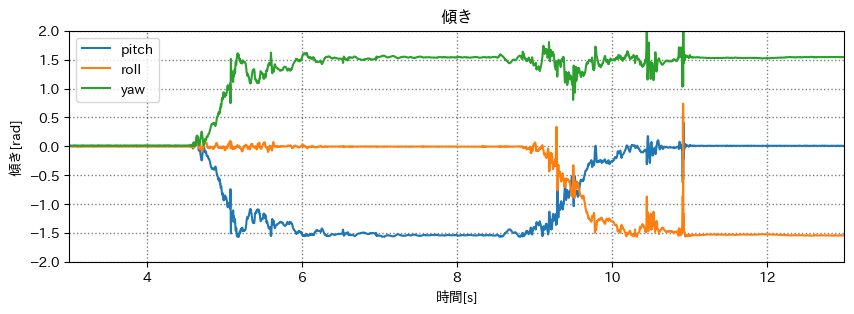

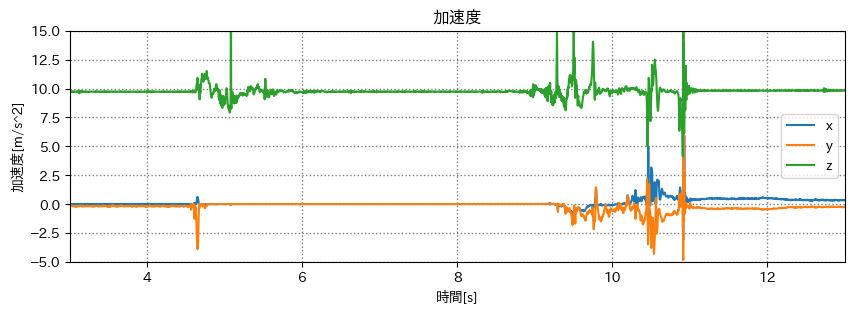

In [196]:
rotated_df_acc = rotate_device_coordinate_system(df_acc)

plot(
    df_tilt,
    heads=[
        ('time', 'pitch'),
        ('time', 'roll'),
        ('time', 'yaw'),
    ],
    title="傾き",
    xlabel="時間[s]",
    ylabel="傾き[rad]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-2, 2),
    grid=True
)

plot(
    rotated_df_acc,
    heads=[
        ('time', 'x'),
        ('time', 'y'),
        ('time', 'z'),
    ],
    title="加速度",
    xlabel="時間[s]",
    ylabel="加速度[m/s^2]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-5, 15),
    grid=True
)
